In [1]:
import pandas as pd
import numpy as np                     # For mathematical calculations
import seaborn as sns                  # For data visualization
import matplotlib.pyplot as plt        # For plotting graphs
%matplotlib inline
import warnings                        # To ignore any warnings
warnings.filterwarnings("ignore")
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

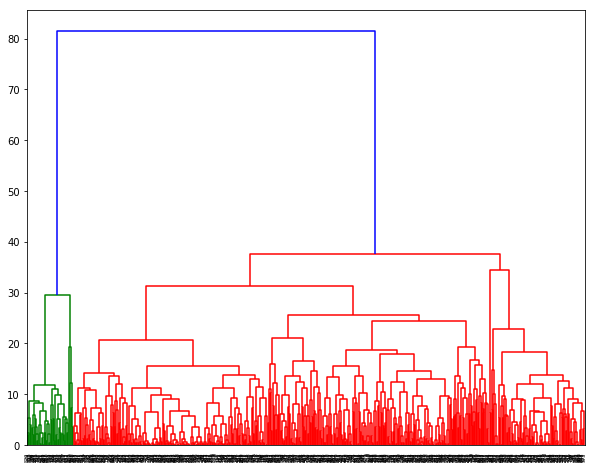

In [2]:
train['Dependents'].replace('3+', 4,inplace=True)
test['Dependents'].replace('3+', 4,inplace=True)
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
train['Married'].fillna(train['Married'].mode()[0], inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
train['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
test['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Dependents'].fillna(train['Dependents'].mode()[0], inplace=True)
test['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Credit_History'].fillna(train['Credit_History'].mode()[0], inplace=True)
test['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0], inplace=True)
test['LoanAmount'].fillna(train['LoanAmount'].median(), inplace=True)
train=train.iloc[:,1:]
train.replace("Male",1,inplace=True)
train.replace("Female",0,inplace=True)
train["Married"].replace("No",0,inplace=True)
train["Married"].replace("Yes",1,inplace=True)
train["Education"].replace("Graduate",1,inplace=True)
train["Education"].replace("Not Graduate",0,inplace=True)
train["Self_Employed"].replace("No",0,inplace=True)
train["Self_Employed"].replace("Yes",1,inplace=True)
train["Property_Area"].replace("Urban",1,inplace=True)
train["Property_Area"].replace("Rural",0,inplace=True)
train["Property_Area"].replace("Semiurban",0.5,inplace=True)
train["total_income"]=train["ApplicantIncome"]+train["CoapplicantIncome"]
test["total_income"]=test["ApplicantIncome"]+test["CoapplicantIncome"]
train["EMI"]=train["LoanAmount"]*1000/train["Loan_Amount_Term"]
test["EMI"]=test["LoanAmount"]*1000/test["Loan_Amount_Term"]
train=train.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)
test=test.drop(["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"],axis=1)
train["total_income"]=np.log(train["total_income"])
test["total_income"]=np.log(test["total_income"])
train["EMI"]=np.log(train["EMI"])
test["EMI"]=np.log(test["EMI"])
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
d=pairwise_distances(X=train.iloc[:,:-1],n_jobs=-1)
links_train=linkage(y=d,method="complete")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
dend=dendrogram(links_train)



In [3]:
cluster_2_train=cut_tree(links_train,height=50).flatten()
cluster_3_train=cut_tree(links_train,height=35).flatten()
cluster_6_train=cut_tree(links_train,height=28).flatten()
np.unique(cluster_3_train)

array([0, 1, 2])

In [4]:
train["cluster"]=cluster_3_train

In [5]:
y=train["Loan_Status"]
x=train.drop("Loan_Status",axis=1)

In [6]:
x=pd.get_dummies(x)
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(x,y, test_size =0.3)


In [118]:
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression()
model.fit(x_train, y_train)
pred=model.predict(x_cv)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
knn=KNeighborsClassifier()
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
knn_bagged=BaggingClassifier(base_estimator=knn,n_estimators=50,random_state=1234)
knn_bagged_param_grid={'n_estimators':[30,50,70,100],'base_estimator__n_neighbors':[1,3,5,7]}
best_bagged_knn=GridSearchCV(estimator=knn_bagged,param_grid=knn_bagged_param_grid,scoring='roc_auc',n_jobs=-1,cv=5)
best_bagged_knn.fit(x,y)
pred_knn_bagged=best_bagged_knn.predict(x)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tree_base=DecisionTreeClassifier()
tree_bagged=BaggingClassifier(base_estimator=tree_base)
tree_bagged_param_grid={'n_estimators':[50,100],'base_estimator__max_depth':[5,7,9],'base_estimator__criterion':['gini','entropy']}
best_bagged_tree=GridSearchCV(estimator=tree_bagged,param_grid=tree_bagged_param_grid,scoring='roc_auc',n_jobs=-1,cv=5)
best_bagged_tree.fit(x_train,y_train)
pred_tree_bagged=best_bagged_tree.predict(x_cv)


In [12]:
pred_tree_random.shape

(185,)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.metrics import accuracy_score,cohen_kappa_score

rf=RandomForestClassifier()
rf_param={"n_estimators":[50,60,100],'max_features':[7,9]}
best_rf=GridSearchCV(estimator=rf,param_grid=rf_param,scoring='accuracy',cv=5,n_jobs=-1)
best_rf.fit(x_train,y_train)
pred_tree_random=best_rf.predict(x_cv)
cohen_kappa_score(y_cv,pred_tree_random),accuracy_score(y_cv,pred_tree_random)

(0.5377451351555993, 0.8216216216216217)

In [119]:
print("logistic regression",cohen_kappa_score(pred,y_cv),accuracy_score(pred,y_cv))
print("knn_bagged",cohen_kappa_score(y,pred_knn_bagged),accuracy_score(y,pred_knn_bagged))
print("tree_bagged",cohen_kappa_score(pred_tree_bagged,y_cv),accuracy_score(y_cv,pred_tree_bagged))

logistic regression 0.4911591355599214 0.8108108108108109
knn_bagged 0.48054145516074454 0.8061889250814332
tree_bagged 0.49630493971217426 0.8108108108108109


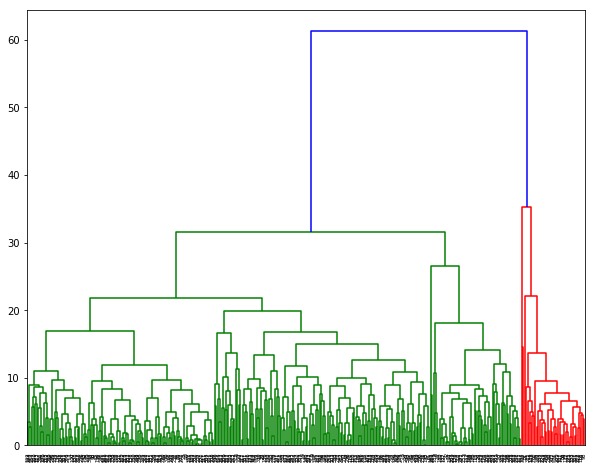

In [14]:
test.replace("Male",1,inplace=True)
test.replace("Female",0,inplace=True)
test["Married"].replace("No",0,inplace=True)
test["Married"].replace("Yes",1,inplace=True)
test["Education"].replace("Graduate",1,inplace=True)
test["Education"].replace("Not Graduate",0,inplace=True)
test["Self_Employed"].replace("No",0,inplace=True)
test["Self_Employed"].replace("Yes",1,inplace=True)
test["Property_Area"].replace("Urban",1,inplace=True)
test["Property_Area"].replace("Rural",0,inplace=True)
test["Property_Area"].replace("Semiurban",0.5,inplace=True)
test=test.iloc[:,1:]
d=pairwise_distances(X=test,n_jobs=-1)
links_test=linkage(y=d,method="complete")
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
dend=dendrogram(links_test)

In [18]:
cluster_3_test=cut_tree(links_test,height=35).flatten()
np.unique(cluster_3_test)

array([0, 1, 2])

In [19]:
test["cluster"]=cluster_3_test

In [20]:
x.columns,test.columns

(Index(['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History',
        'Property_Area', 'total_income', 'EMI', 'cluster', 'Dependents_4',
        'Dependents_0', 'Dependents_1', 'Dependents_2'],
       dtype='object'),
 Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
        'Credit_History', 'Property_Area', 'total_income', 'EMI', 'cluster'],
       dtype='object'))

In [22]:
test=pd.get_dummies(test)

In [23]:
solution=best_rf.predict(test)


In [24]:
sample_submission=pd.read_csv("Sample_Submission.csv")
test=pd.read_csv("test.csv")
sample_submission["Loan_ID"]=test["Loan_ID"]
sample_submission["Loan_Status"]=solution
sample_submission["Loan_Status"]=sample_submission["Loan_Status"].replace(1,"Y")
sample_submission["Loan_Status"]=sample_submission["Loan_Status"].replace(0,"N")
sample_submission.to_csv("Sample_Submission.csv",index=False)